Marcin Grzyb marcingrzyb@student.agh.edu.pl 
Paweł Gałka pawelgalka@student.agh.edu.pl

In [1]:
!git clone https://github.com/marcingrzyb/computational-intelligence-data.git

Cloning into 'computational-intelligence-data'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [0]:
import tensorflow.keras
import numpy as np

In [0]:
#Settings to get reproducible results
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(2)
tensorflow.random.set_seed(2)


In [4]:
from pandas import read_csv
from pandas import get_dummies
from sklearn.model_selection import train_test_split

dataset=read_csv('/content/computational-intelligence-data/project3/imports-85.data',header=None,names=['symboling',
'normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine_location','wheel-base','length',
'width','height','curb-weight','engine-type','num_of_cylinders','engine-size','fuel_system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price'])
print(dataset.shape)

dataset.replace('?',np.NaN,inplace=True)

#deleting NaN values
dataset.dropna(inplace=True)
print(dataset.shape)

dataset['num_of_cylinders'].replace(dict(zip(['eight','five', 'four', 'six', 'three', 'twelve', 'two'], [8,5,4,6,3,12,2])),inplace=True)
#replacing two value variables to bools
dataset.replace(dict.fromkeys(['diesel','std','two','rear'], False),inplace=True)
dataset.replace(dict.fromkeys(['gas','turbo','four','front'], True),inplace=True)

#print(dataset.to_string())
#print(dataset.dtypes)


categoricalCols=['body-style', 'drive-wheels', 'make', 'engine-type','fuel_system']

#detecting records that may affect model in the wrong way(fore example only 2 occurences of convertible body style)
for col in dataset.columns:
  print(dataset[col].value_counts())


#hardtop is also convertible so we can change hardtop to convertible
dataset['body-style'].replace('hardtop','convertible',inplace=True)
#single occurence
dataset=dataset[dataset.fuel_system != 'mfi'] 
dataset=dataset[dataset.make != 'porsche'] 
dataset=dataset[dataset.make != 'jaguar'] 
dataset=dataset[dataset.num_of_cylinders != 3] 
dataset=dataset[dataset.num_of_cylinders != 8]
#engine location has only 1 value-True deleting col
dataset.drop('engine_location',axis=1,inplace=True)

for col in categoricalCols:
    dataset[col] = dataset[col].astype('category')

#one hot encoding for categorical variables
datasetOnehot = get_dummies(dataset, columns=categoricalCols, prefix = categoricalCols)
print(datasetOnehot.shape)

(205, 26)
(159, 26)
 0    48
 1    46
 2    29
-1    20
 3    13
-2     3
Name: symboling, dtype: int64
161    11
91      8
134     6
104     6
128     6
103     5
94      5
95      5
74      5
102     5
65      5
168     5
85      5
93      4
118     4
122     4
106     4
148     3
154     3
115     3
101     3
125     3
150     3
83      3
137     3
81      2
87      2
89      2
153     2
158     2
145     2
119     2
113     2
194     2
129     2
110     2
197     2
164     2
108     2
188     2
192     2
77      1
78      1
98      1
256     1
142     1
121     1
90      1
186     1
107     1
231     1
Name: normalized-losses, dtype: int64
toyota           31
nissan           18
honda            13
subaru           12
volvo            11
mazda            11
mitsubishi       10
volkswagen        8
dodge             8
peugot            7
plymouth          6
saab              6
mercedes-benz     5
audi              4
bmw               4
chevrolet         3
porsche           1
jaguar  

In [0]:
price=datasetOnehot.pop('price')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(datasetOnehot,price, test_size=0.33, random_state=42)
#create validation set from train
X_train, X_Validation, y_train, y_Validation = train_test_split(X_train,y_train, test_size=0.25, random_state=42)



X_train=np.asarray(X_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)

X_Validation=np.asarray(X_Validation).astype(np.float32)
y_Validation=np.asarray(y_Validation).astype(np.float32)

X_test=np.asarray(X_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)


In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(X_Validation.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model

In [0]:
from tensorflow.keras import backend as K

# Some memory clean-up
K.clear_session()

In [9]:
import numpy as np

k = len(X_Validation)
num_epochs=100
num_val_samples = len(X_Validation) // k
all_scores = []
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  # Prepare the validation data: data from partition # k
  val_data = X_Validation[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = y_Validation[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepare the training data: data from all other partitions
  partial_train_data = np.concatenate(
      [X_Validation[:i * num_val_samples],
      X_Validation[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [y_Validation[:i * num_val_samples],
      y_Validation[(i + 1) * num_val_samples:]],
      axis=0)
  
  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  history=model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=1)
  # Evaluate the model on the validation data
  print(history.history.keys())
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
  all_scores.append(val_mae)
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)


Streaming output truncated to the last 5000 lines.
25/25 [==============================] - 0s 1ms/step - loss: 14178890.0000 - mean_absolute_error: 2493.6514
Epoch 39/100
25/25 [==============================] - 0s 1ms/step - loss: 13422655.0000 - mean_absolute_error: 2455.6826
Epoch 40/100
25/25 [==============================] - 0s 1ms/step - loss: 12763232.0000 - mean_absolute_error: 2449.7666
Epoch 41/100
25/25 [==============================] - 0s 1ms/step - loss: 12243844.0000 - mean_absolute_error: 2105.5149
Epoch 42/100
25/25 [==============================] - 0s 1ms/step - loss: 12043487.0000 - mean_absolute_error: 2210.5754
Epoch 43/100
25/25 [==============================] - 0s 1ms/step - loss: 11052385.0000 - mean_absolute_error: 2104.5879
Epoch 44/100
25/25 [==============================] - 0s 1ms/step - loss: 10708035.0000 - mean_absolute_error: 2209.9417
Epoch 45/100
25/25 [==============================] - 0s 1ms/step - loss: 10655368.0000 - mean_absolute_error: 2031

In [10]:
print(np.mean(all_scores))
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

1447.847393329327


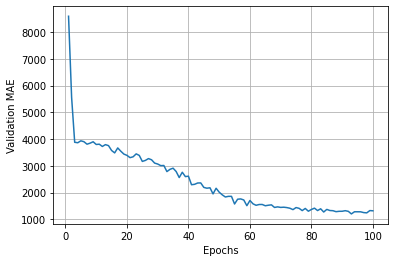

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.show()

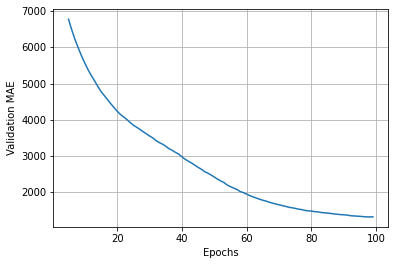

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(5, len(smooth_mae_history) ), smooth_mae_history[5:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.show()

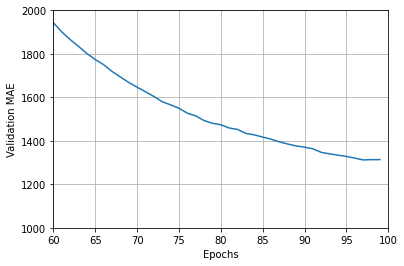

In [17]:
smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(5, len(smooth_mae_history) ), smooth_mae_history[5:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.ylim(1000,2000)
plt.xlim(60,100)
plt.grid()
plt.show()

In [13]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(X_train, y_train,
          epochs=100, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 4817344.0000 - mean_absolute_error: 1450.4142
